In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import nds2 
from astropy.time import Time
import time
import timeit
import sys
import scipy.signal as sig
from get_scan_coords import *
sys.path.append('hoak/')
import h5py

In [3]:
OMC_chans = ['H1:OMC-DCPD_SUM_OUTPUT' , 'H1:OMC-DCPD_A_OUTPUT' , 'H1:OMC-DCPD_B_OUTPUT' , 'H1:OMC-PZT2_MON_DC_OUTPUT' , 'H1:OMC-PZT1_MON_DC_OUTPUT' , 'H1:OMC-PZT2_OFFSET' , 'H1:OMC-LSC_SERVO_GAIN' , 'H1:OMC-LSC_SERVO_INMON' , 'H1:OMC-LSC_SERVO_OUTPUT' , 'H1:GRD-OMC_LOCK_STATE_N']
TCS_chans = ['H1:TCS-ITMX_CO2_LSRPWR_MTR_OUTPUT' , 'H1:TCS-ITMY_CO2_LSRPWR_MTR_OUTPUT' , 'H1:TCS-ITMX_HWS_PROBE_SPHERICAL_POWER' , 'H1:TCS-ITMY_HWS_PROBE_SPHERICAL_POWER']
Pin_chan = 'H1:IMC-PWR_IN_OUT16'
darm_offset_chan  = ['H1:LSC-DARM1_OFFSET' , 'H1:LSC-DARM1_OUT16']         #super small, might just want to find out when it is 0 and when it is not

In [4]:
chans = [OMC_chans[0], OMC_chans[3], Pin_chan] + TCS_chans

Note: H1:GRD-OMC_LOCK_STATE_N is in PREP_OMC_SCAN if the index is 140

In [5]:
chans

['H1:OMC-DCPD_SUM_OUTPUT',
 'H1:OMC-PZT2_MON_DC_OUTPUT',
 'H1:IMC-PWR_IN_OUT16',
 'H1:TCS-ITMX_CO2_LSRPWR_MTR_OUTPUT',
 'H1:TCS-ITMY_CO2_LSRPWR_MTR_OUTPUT',
 'H1:TCS-ITMX_HWS_PROBE_SPHERICAL_POWER',
 'H1:TCS-ITMY_HWS_PROBE_SPHERICAL_POWER']

## Fetching scan data and saving to .h5 

In [6]:
# 2W to 5W to 10 W measurement (M1)
t_start = 1239402800
t_end  = 1239405898

#35W thermal state measurment (scan at 10W)
t2_start = 1239414600
t2_end = 1239415203

start = 1239388150
end = 1239416886


In [7]:
conn = nds2.connection('h1nds1', 8088)

In [8]:
# Fetching data from (M1 AND M2)
print('Fetching data...') 
tic = timeit.default_timer()
data_M1 = conn.fetch(start, end, chans) 
toc = timeit.default_timer() - tic
print('Got data: Elapsed time = ' + str(round(toc,1)) + ' s')

# Measurement 1 .hf file
h5f = h5py.File('meas_tot.h5','w')
for i in range(0, len(data_M1)):
    h5f.create_dataset(data_M1[i].name,data=data_M1[i].data) #operating at low Z for these scans
    h5f[data_M1[i].name].attrs['sample_rate'] = data_M1[i].sample_rate
h5f.close()

Fetching data...
Got data: Elapsed time = 55.6 s


In [8]:
# Fetching data from (M1)
print('Fetching data...') 
tic = timeit.default_timer()
data_M1 = conn.fetch(t_start, t_end, chans) 
toc = timeit.default_timer() - tic
print('Got data: Elapsed time = ' + str(round(toc,1)) + ' s')

# Measurement 1 .hf file
h5f = h5py.File('meas1.h5','w')
for i in range(0, len(data_M1)):
    h5f.create_dataset(data_M1[i].name,data=data_M1[i].data) #operating at low Z for these scans
    h5f[data_M1[i].name].attrs['sample_rate'] = data_M1[i].sample_rate
h5f.close()

Fetching data...
Got data: Elapsed time = 6.7 s


In [9]:
data_M1[0].data

array([0.01303692, 0.04687005, 0.46521375, ..., 1.3706818 , 1.9896387 ,
       1.7422056 ], dtype=float32)

In [756]:
#Fetching data from (M2)
tic = timeit.default_timer()
data_M2 = conn.fetch(t2_start, t2_end, chans)
toc = timeit.default_timer() - tic
print('Got data: Elapsed time = ' + str(round(toc,1)) + ' s')

# Measurement 2 .hf file
h5f = h5py.File('meas2.h5','w')
for i in range(0, len(data_M2)):
    h5f.create_dataset(data_M2[i].name,data=data_M2[i].data) #operating at low Z for these scans
    h5f[data_M2[i].name].attrs['sample_rate'] = data_M2[i].sample_rate
h5f.close()

Got data: Elapsed time = 0.5 s


In [246]:
h5f1.keys()

[u'H1:IMC-PWR_IN_OUT16',
 u'H1:OMC-DCPD_SUM_OUTPUT',
 u'H1:OMC-PZT2_MON_DC_OUTPUT',
 u'H1:TCS-ITMX_CO2_LSRPWR_MTR_OUTPUT',
 u'H1:TCS-ITMX_HWS_PROBE_SPHERICAL_POWER',
 u'H1:TCS-ITMY_CO2_LSRPWR_MTR_OUTPUT',
 u'H1:TCS-ITMY_HWS_PROBE_SPHERICAL_POWER']

## Grabbing data from .h5

In [6]:
# Measurment 1 data
h5f1 = h5py.File('meas1.h5','r')
names = h5f1.keys()
sample_rates = []
sample_rates = [h5f1[names[i]].attrs['sample_rate'] for i in range(0,len(names))]
PSL = h5f1[names[0]]
DCPD = h5f1[names[1]]
PZT = h5f1[names[2]]
CO2X = h5f1[names[3]]
HWSX = h5f1[names[4]]
CO2Y = h5f1[names[5]]
HWSY = h5f1[names[6]]

In [8]:
#time series
f_s = 16
b = len(PSL)
t  = np.linspace(0, float(b)/float(f_s), b)
print(f_s)

16


In [9]:
#Low pass for data conditioning
b, a = sig.butter(2, 0.0001)

## CO2 and Pin trend during M1

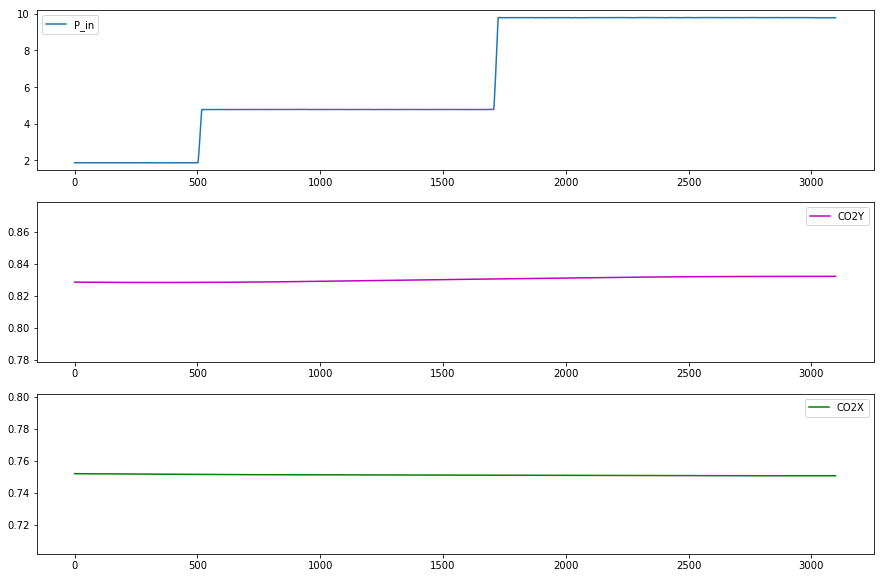

In [11]:
#CO2 trend during the measurment
plt.figure(figsize=(15,10))
#plt.plot(t,CO2Y)]
plt.subplot(311)
plt.plot(t, PSL, label='P_in')
plt.legend()
plt.subplot(312)
plt.plot(t, sig.filtfilt(b,a,CO2Y),'m',label='CO2Y')
plt.ylim([CO2Y[0]-.05,CO2Y[0]+.05])
plt.legend()
#plt.plot(t,CO2X) 
plt.subplot(313)
plt.plot(t, sig.filtfilt(b,a,CO2X), 'g' ,label='CO2X')
plt.ylim([CO2X[0]-.05,CO2X[0]+.05])
plt.legend()


## HWS trend during M1

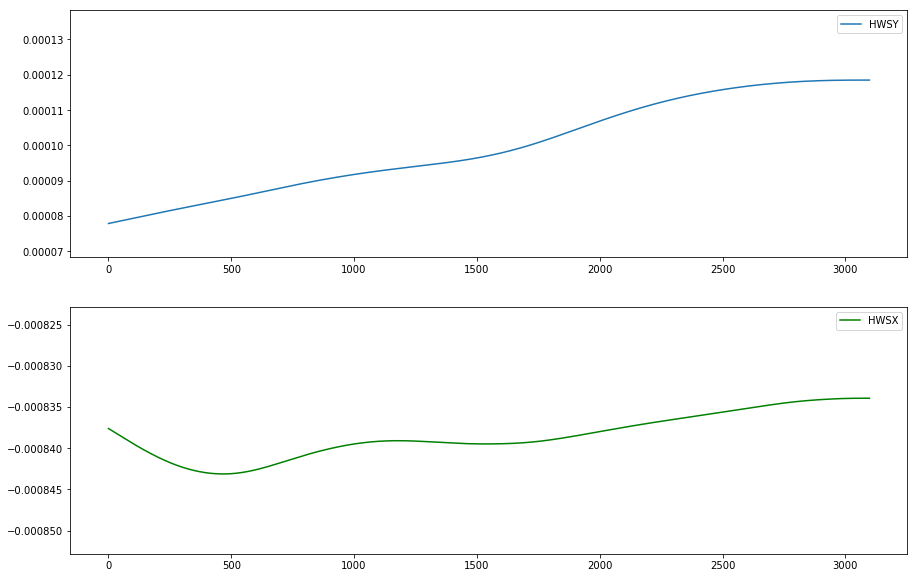

In [366]:
#HWS trend during the measurment
plt.figure(figsize=(15,10))
plt.subplot(211)
#plt.plot(t,HWSY)
plt.plot(t, sig.filtfilt(b,a,HWSY), label='HWSY')
plt.ylim([HWSY[0]-10*1e-6,HWSY[0]+60e-6])
plt.legend()
plt.subplot(212)
#plt.plot(t,HWSX)
plt.plot(t, sig.filtfilt(b,a,HWSX), 'g',label='HWSX')
plt.ylim([HWSX[0]-20*1e-6,HWSX[0]+10e-6])
plt.legend()


In [656]:
a = get_scan_coords(PZT)
a = a.astype(int)

element= []
for i in range(0,len(a)):
    if  (a[i][1]-a[i][0])<1000:
        element.append(i)

#a = np.delete(a, element)

In [657]:
a = np.delete(a,(element), axis=0)

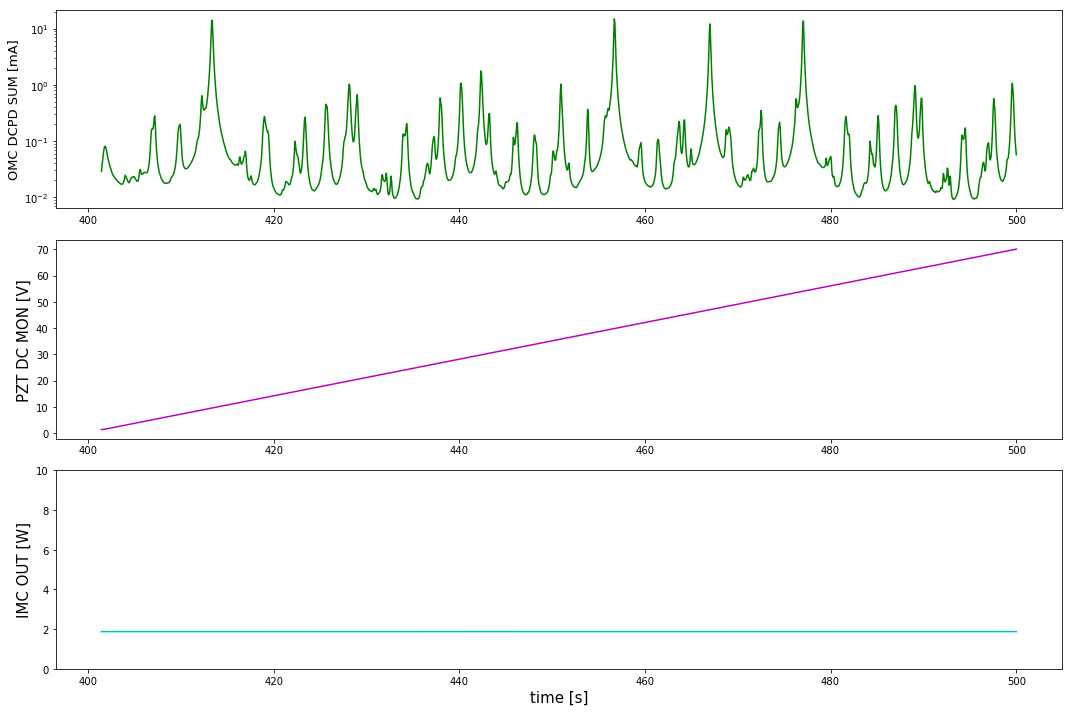

In [654]:
plt.figure(figsize=(15,10))
i = 4

plt.subplot(311)
plt.semilogy(t[a[i][0]:a[i][1]],DCPD[a[i][0]:a[i][1]],'g')
plt.ylabel('OMC DCPD SUM [mA]',FontSize='13')
#plt.title()

plt.subplot(312)
plt.plot(t[a[i][0]:a[i][1]],PZT[a[i][0]:a[i][1]],'m')
plt.ylabel('PZT DC MON [V]',FontSize='15')

plt.subplot(313)
plt.plot(t[a[i][0]:a[i][1]],PSL[a[i][0]:a[i][1]],'c')
plt.ylim([0,10])
plt.ylabel('IMC OUT [W]',FontSize='15')
plt.xlabel('time [s]',FontSize='15')
plt.tight_layout()

In [658]:
a

array([[   24,  1601],
       [ 1623,  3201],
       [ 3223,  4801],
       [ 4824,  6401],
       [ 6423,  8001],
       [ 8024,  9601],
       [ 9624, 11201],
       [11223, 12801],
       [12826, 14401],
       [14423, 16001],
       [16023, 17601],
       [17624, 19201],
       [19223, 20801],
       [20824, 22277],
       [22425, 24001],
       [24025, 25601],
       [25623, 27201],
       [27223, 28801],
       [28822, 30401],
       [30424, 32001],
       [32023, 33601],
       [33624, 35201],
       [35223, 36801],
       [36823, 38401],
       [38424, 40001],
       [40023, 41601],
       [41624, 43201],
       [43223, 44801],
       [44825, 46401],
       [46423, 48001]])

## Peak identification and time to frequency fitting

In [659]:
# Find most prominent peaks in scan and use
peaks_45MHz = np.zeros(len(a))
peaks_45MHz = [[] for i in range(0,len(peaks_45MHz))]
for i in range(0,len(peaks_45MHz)): 
    peaks_45MHz[i] = sig.find_peaks(DCPD[a[i][0]:a[i][1]], height= 10.5)
        
# Double check scans (sorting algorithm in  may not be optimal)
element= []
for i in range(0,len(peaks_45MHz)):
    if  len(peaks_45MHz[i][0])==0:
        element.append(i)
        
#peaks_45MHz = np.delete(peaks_45MHz,element)


In [660]:
peaks_45MHz

[(array([ 165,  862, 1027, 1188]),
  {'peak_heights': array([14.128829  , 14.04335785, 11.28744221, 15.60865593])}),
 (array([ 179,  875, 1039, 1200]),
  {'peak_heights': array([14.9360733 , 14.37803555, 12.73462868, 15.57961178])}),
 (array([ 185,  880, 1205]),
  {'peak_heights': array([14.7882328 , 14.55376625, 15.50007725])}),
 (array([ 187,  881, 1046, 1207]),
  {'peak_heights': array([15.5436964 , 14.85105991, 11.77445126, 15.33263683])}),
 (array([ 191,  884, 1049, 1210]),
  {'peak_heights': array([14.13607693, 14.89497375, 12.13446617, 13.73724842])}),
 (array([ 191,  885, 1210]),
  {'peak_heights': array([33.08555984, 39.95871353, 39.77852631])}),
 (array([ 192,  886, 1211]),
  {'peak_heights': array([38.87677383, 38.23788071, 40.07078552])}),
 (array([ 194,  887, 1213]),
  {'peak_heights': array([39.81891251, 37.11691284, 37.08030319])}),
 (array([ 192,  885, 1210]),
  {'peak_heights': array([39.9615097 , 41.60422516, 35.35975266])}),
 (array([ 195,  889, 1214]),
  {'peak_heig

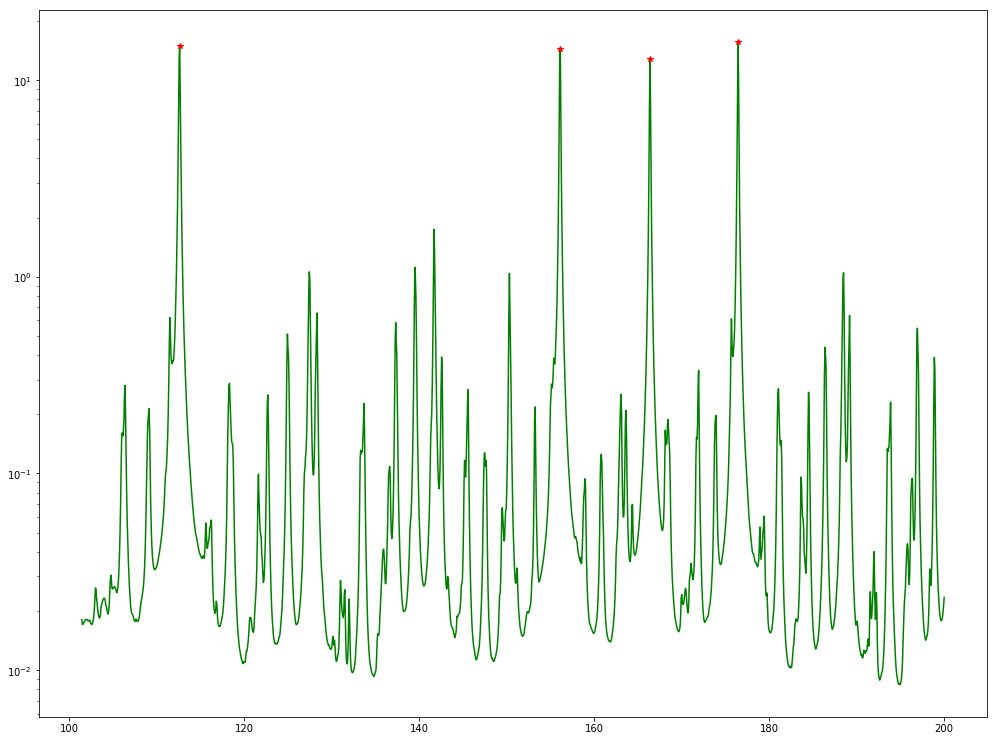

In [685]:
i = 1

plt.figure(figsize=(17,13))

plt.semilogy(t[a[i][0]:a[i][1]],DCPD[a[i][0]:a[i][1]],'g')
select_peaks = [a[i][0] + p for p in peaks_45MHz[i][0][:]] 
plt.semilogy(t[select_peaks],DCPD[select_peaks],'r*')

## Overlapping scans

In [808]:
i = 0
for k in range(0,len(peaks_45MHz)):
    fig = plt.figure(figsize=(17,13))
    PZT_offset = PZT[peaks_45MHz[k][0][0]] -PZT[peaks_45MHz[i][0][0]]
    plt.semilogy(PZT[a[i][0]:a[i][1]],DCPD[a[i][0]:a[i][1]],'g')
    if PZT_offset > 0:
        plt.semilogy(PZT[a[k][0]:a[k][1]]-PZT_offset,DCPD[a[k][0]:a[k][1]],'m')
    else:
        plt.semilogy(PZT[a[k][0]:a[k][1]]+PZT_offset,DCPD[a[k][0]:a[k][1]],'m')
    plt.ylim([0,50])
    plt.xlabel('PZT voltage [V]',FontSize=16)
    plt.ylabel('DCPD SUM [mA]', FontSize=16)
    if k<10:
        fig.savefig('scan_compare/scan_0{}.png'.format(k))
    else:
        fig.savefig('scan_compare/scan_{}.png'.format(k))
    plt.close()


#### Peaks shift as a function of time. Not only an offset but also a change in the fitting (PZT hysteresis). Peforming fit for every scan to mitigate these effects.

In [814]:
order_poly=3
coeffs = [[] for i in range(0,len(peaks_45MHz))]
res = [[] for i in range(0,len(peaks_45MHz))]
PZT_peaks = [[] for i in range(0,len(peaks_45MHz))]
for i in range(0, len(peaks_45MHz)):
    ind_offset = peaks_45MHz[i][0][:] + a[i][0]
    for k in peaks_45MHz[0][0][:]: 
        PZT_peaks[i].append(k + a[i][0])
    out1, out2, _, _, _ = np.polyfit(PZT[PZT_peaks[i]],[f5, FSR-f5, FSR,FSR+f5],order_poly, full=True)
    coeffs[i] = out1
    res[i] = out2
    

In [815]:
# time to frequency polynomial
def pzt_fit(pzt, coef ,order):
    forward = range(order+1)
    back = forward[::-1]
    freq = np.zeros(len(pzt))
    for i in forward: 
        freq = freq + [coef[back[i]]*(w**forward[i]) for w in pzt]
    return freq

In [829]:
freq = [[] for i in range(len(PZT_peaks))]
freq = [pzt_fit(PZT[a[i][0]:a[i][1]],coeffs[i],order_poly) for i in range(len(coeffs))]

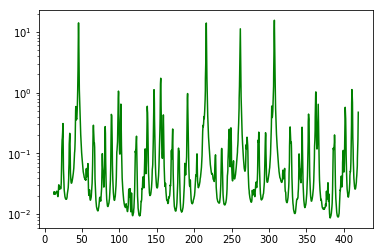

In [849]:
plt.semilogy(freq[0],DCPD[a[0][0]:a[0][1]],'g')

In [848]:
freq[a[0][0]:a[0][1]]

[array([ 12.54214812,  12.71229179,  12.81278339, ..., 418.90523026,
        419.15731831, 419.43457242]),
 array([ 13.42802662,  13.48154789,  13.51374014, ..., 417.48195272,
        417.80546025, 418.10976261]),
 array([ 13.21877884,  13.28486653,  13.42261315, ..., 417.15987244,
        417.49844823, 417.83842485]),
 array([ 12.99572683,  13.01285497,  13.11899789, ..., 418.22527697,
        418.46040537, 418.81050134]),
 array([ 11.9829307 ,  12.03454951,  12.23160828, ..., 419.3932503 ,
        419.68828963, 419.98859081]),
 array([ 13.07213221,  13.11975787,  13.1979157 , ..., 418.41355915,
        418.6804722 , 418.98431921])]

In [850]:
i = 0
for k in range(0,len(peaks_45MHz)):
    fig = plt.figure(figsize=(17,13))
    freq_offset = freq[k][peaks_45MHz[k][0][0]]-freq[i][peaks_45MHz[i][0][0]]
    plt.semilogy(freq[i],DCPD[a[i][0]:a[i][1]],'g')
    if freq_offset > 0:
        plt.semilogy(freq[k]-freq_offset,DCPD[a[k][0]:a[k][1]],'m')
    else:
        plt.semilogy(freq[k]+freq_offset,DCPD[a[k][0]:a[k][1]],'m')
    plt.ylim([0,50])
    plt.xlabel('frequency [Hz]',FontSize=16)
    plt.ylabel('DCPD SUM [mA]', FontSize=16)
    if k<10:
        fig.savefig('scan_compare_freq/scan_0{}.png'.format(k))
    else:
        fig.savefig('scan_compare_freq/scan_{}.png'.format(k))
    plt.close()


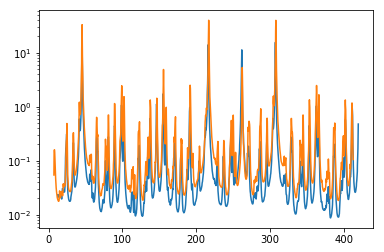

In [844]:
freq_offset = freq[5][peaks_45MHz[5][0][0]]-freq[0][peaks_45MHz[0][0][0]]
plt.semilogy(freq[0],DCPD[a[0][0]:a[0][1]])
plt.semilogy(freq[5]-freq_diff,DCPD[a[5][0]:a[5][1]])

In [842]:
peaks_45MHz[5][0][0]

191

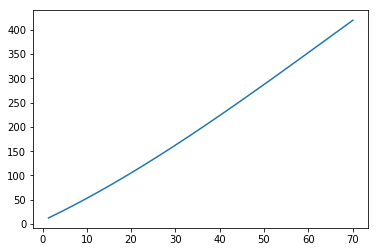

In [825]:
plt.plot(PZT[a[1][0]:a[1][1]],test_freq)

In [ ]:
for k in range(0,len(peaks_45MHz)):
    fig = plt.figure(figsize=(17,13))
    PZT_offset = PZT[peaks_45MHz[k][0][0]] -PZT[peaks_45MHz[i][0][0]]
    plt.semilogy(PZT[a[i][0]:a[i][1]],DCPD[a[i][0]:a[i][1]],'g')
    if PZT_offset > 0:
        plt.semilogy(PZT[a[k][0]:a[k][1]]-PZT_offset,DCPD[a[k][0]:a[k][1]],'m')
    else:
        plt.semilogy(PZT[a[k][0]:a[k][1]]+PZT_offset,DCPD[a[k][0]:a[k][1]],'m')
    plt.ylim([0,50])
    plt.xlabel('PZT voltage [V]',FontSize=16)
    plt.ylabel('DCPD SUM [mA]', FontSize=16)
    if k<10:
        fig.savefig('scan_compare/scan_0{}.png'.format(k))
    else:
        fig.savefig('scan_compare/scan_{}.png'.format(k))

In [693]:
PZT_peaks = []
for i in peaks_45MHz[0][0][:]: 
    PZT_peaks.append(i + a[0][0])
    
    

In [101]:
# Modulation frequencies
f1 = 9.10023
f5 = f1*5

# OMC parameters measured by Koji
FSR = 261710400.0*1e-6
TMS = 57982266.0*1e-6
fines = 375.5

In [781]:
#plt.plot(PZT[peaks_45MHz[0][0][:] + a[0][0]],[f5, FSR-f5, FSR,FSR+f5],'k--')
p, res, _, _, _ = np.polyfit(PZT[PZT_peaks[0]],[f5, FSR-f5, FSR,FSR+f5],3, full=True)
p

array([-1.61575171e-04,  3.37592444e-02,  4.31918777e+00,  6.59909105e+00])

In [165]:
res

array([], dtype=float64)

In [786]:
# time to frequency polynomial
def pzt_fit(volts):
  return p[0] * volts**3 + p[1] * volts**2 + p[2] * volts + p[3]

In [787]:
pzt_fit(PZT)

TypeError: unsupported operand type(s) for ** or pow(): 'Dataset' and 'int'

In [772]:
#Double check fit
test_v = np.arange(0,70,.1)
y = [pzt_fit(i) for i in test_v]
plt.plot(test_v,y)
plt.plot(PZT[peaks_45MHz[0][0][:] + a[0][0]],[f5, FSR-f5, FSR,FSR+f5],'k*')

IndexError: invalid index to scalar variable.

In [172]:
## What if we don't use the polynomial and assume it's linear?

#Get the frequency to PZT voltage, to time conversion
#PZT to time
alpha = 70.0/100.0 # .7 volts/second
t_FSR  = (PZT[peaks_45MHz[0][0][3]]-PZT[peaks_45MHz[0][0][0]])/alpha
beta = (FSR)/t_FSR
print(beta)
#frequency to seconds
t_offset = t[a[0][0]]
print(t_offset)

4.102397116530756
1.5000302620695218


In [173]:
# Very specific lorentzian
def P_circ(nu, fines, fsr, P_max=1): 
    P = P_max/( (1 + (2.0*fines/np.pi)**2 * np.sin((np.pi*nu)/fsr)**2) )
    return P

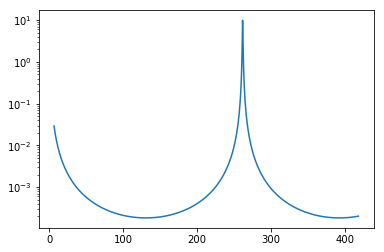

In [174]:
P = [P_circ(i, fines, FSR, P_max=10.5) for i in y]
plt.semilogy(y,P)

In [175]:
#Check that the distance between peaks in P_circ is an FSR
#peaks = sig.find_peaks(P, height= 8)
#print(peaks)
#abs((FSR-(y[peaks[0][1]] - y[peaks[0][0]]))/FSR)

#### Does this up to 17%

In [176]:
o_n = 1
o_n2 = 2
y_1 = []
#y_1 = [(i*4102397.117)+FSR for i in PZT[a[0][0]:a[0][1]]]
y_1 = [pzt_fit(i) for i in PZT[a[0][0]:a[0][1]]]

P_zero = [P_circ(k, fines, FSR, P_max=10.5) for k in y_1]
P_pos = [P_circ(k, fines, FSR+f5, P_max=10.5) for k in y_1]
P_neg = [P_circ(k, fines, FSR-f5, P_max=10.5) for k in y_1]
#P_zero1 = [P_circ(k, fines, FSR+TMS*o_n, P_max=10.5) for k in y_1]
#P_pos1 = [P_circ(k, fines, FSR+f5+TMS*o_n, P_max=10.5) for k in y_1]
#P_neg1 = [P_circ(k, fines, FSR-f5+TMS*o_n, P_max=10.5) for k in y_1]
#P_pos2= [P_circ(k, fines, FSR+TMS*o_n2, P_max=10.5) for k in y_1]
#P_zero2= [P_circ(k, fines, FSR+mod_freq+TMS*o_n2, P_max=10.5) for k in y_1]
#P_neg2= [P_circ(k, fines, FSR-mod_freq+TMS*o_n2, P_max=10.5) for k in y_1]

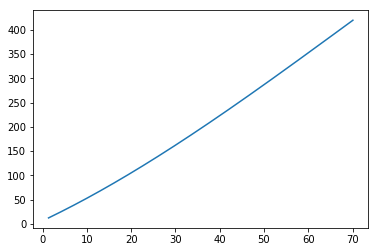

In [177]:
plt.plot(PZT[a[0][0]:a[0][1]], y_1)

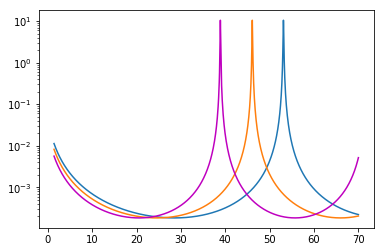

In [178]:
plt.semilogy(PZT[a[0][0]:a[0][1]], P_pos)
plt.semilogy(PZT[a[0][0]:a[0][1]], P_zero)
plt.semilogy(PZT[a[0][0]:a[0][1]], P_neg, 'm')
#plt.semilogy(t[a[0][0]:a[0][1]], P_pos1)
#plt.semilogy(t[a[0][0]:a[0][1]], P_zero1)
#plt.semilogy(t[a[0][0]:a[0][1]], P_neg1)
#plt.semilogy(t[a[0][0]:a[0][1]], P_pos2)
#plt.semilogy(t[a[0][0]:a[0][1]], P_zero2)
#plt.semilogy(t[a[0][0]:a[0][1]], P_neg2)


In [179]:
max(P_pos)
max(P_zero)
max(P_neg)

10.5

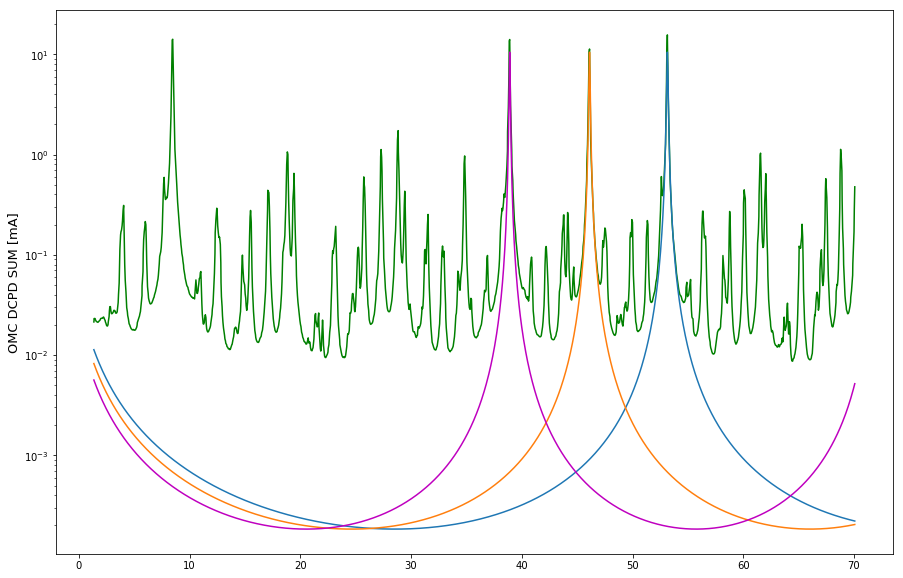

In [180]:
# scan comparison
f = plt.figure(figsize=(15,10))
i = 0
k = 23
plt.semilogy(PZT[a[i][0]:a[i][1]],DCPD[a[i][0]:a[i][1]],'g')
#t_diff = t[a[i+k][0]+peaks_45MHz[i+k][0][0]]-t[a[i][0]+peaks_45MHz[i][0][0]]
#plt.semilogy(t[a[i+k][0]:a[i+k][1]]-t_diff,DCPD[a[i+k][0]:a[i+k][1]],'k')
#plt.semilogy(new_t_45 ,P)
#plt.semilogy(new_t_neg_45,P)
#plt.semilogy(new_t_carr,P)
plt.semilogy(PZT[a[0][0]:a[0][1]], P_pos)
plt.semilogy(PZT[a[0][0]:a[0][1]], P_zero)
plt.semilogy(PZT[a[0][0]:a[0][1]], P_neg,'m')
#plt.semilogy(PZT[a[0][0]:a[0][1]], P_pos1)
#plt.semilogy(PZT[a[0][0]:a[0][1]], P_zero1)
#plt.semilogy(PZT[a[0][0]:a[0][1]], P_neg1)
#plt.semilogy(t[a[0][0]:a[0][1]], P_pos2)
#plt.semilogy(t[a[0][0]:a[0][1]], P_zero2)
#plt.semilogy(t[a[0][0]:a[0][1]], P_neg2)
plt.ylabel('OMC DCPD SUM [mA]',FontSize='13')

#### Doesn't agree too well

# Dan Hoak's fitting routine

In [181]:
## Dan Hoak functions

def lorentzian_error_function(params,x,data):

    A = params['A'].value
    f0 = params['f0'].value
    fc = params['fc'].value
    fit = A/(1.0+((x-f0)/fc)**2)
    return data - fit

def fit_peak(volts,data,A0,f0):

    params = Parameters()
    params.add('A', A0, vary=True)
    params.add('f0', f0, vary=True)
    params.add('fc', 0.05, vary=True)

    out = minimize(lorentzian_error_function, params, args=(volts,data), method='nelder')
    out = minimize(lorentzian_error_function, params, args=(volts,data), method='leastsq')

    fit_vals = [params['A'].value, params['f0'].value, params['fc'].value]
    fit_errors = [params['A'].stderr, params['f0'].stderr, params['fc'].stderr]

    return fit_vals, fit_errors

In [192]:
# Mode list
max_HOM = 3.0
order_nums = np.arange(1.0,max_HOM+1.0,1.0)
HOMs = []
HOMs = [TMS*i for i in order_nums]

In [ ]:
h5f1.close()